## Deep learning for stock prediction

### Introduction

Recurrent neural networks are one of the most hot topic in deep learning. Thanks to their capacity to take track of past information they are perfect to analyze and predict sequential data such as text, music, audio and more in general numeric data. In this project I am going to build a recurrent neural network able to predict the stock high of the following day. Since a prediction alone is not enough to extract value from the market, the last part of the notebook will be about the implementation of a basic strategy able to generate profit.

### Setup

In [398]:
# library for data mining
import ffn

# deep learning libraries
import tensorflow as tf
from tensorflow import keras

# common imports
import pandas as pd
import numpy as np

# setting random seed
np.random.seed(42)
tf.random.set_seed(42)

# Style setup
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=12)
plt.style.use('fivethirtyeight')
plt.xkcd(False)
%matplotlib inline

### Load stock historical data

The following function load the daily open-high-low-close for the inputs tickers. The ticker choosen for analysis if Facebook: however if we want to generate more accurate prediction a good starting point could be to gather data about all S&P500 companies: doing so we could take into account also the type of market in which we operate (Bear or Bull) and possible future correlations between differnet stocks

In [299]:
def load_data(tickers, start, end):
    df = pd.DataFrame()
    for ticker in tickers:
        parse_str = ticker + ':Open,' + ticker + ':High,' + ticker + ':Low,' + ticker + ':Close,' + ticker + ':Volume'
        ticker_df = ffn.get(parse_str, start = start, end = end)
        df = pd.concat([df, ticker_df], axis = 1)
    df.dropna(inplace = True)  
    return df

tickers = ['fb']
start = '2000-01-01'; end = '2019-12-31'
df = load_data(tickers, start, end)

### Preprocessing and feature extraction

The next step is to create the inputs for the model. After the MinMaxScaling applied on the whole dataset, We need to create the sequences needed to feed the RNN. Note that if the inputs of the model have a length of 50 time steps (in our case 50 days) the trained network will extract pattern only long maximum 50 days. We can see the sequence length as an hyperparameter: if we want to tune it the best solution is to wrap the preprocessing steps and the model into a pipeline in order to evaluate the entire process. 

In [300]:
from sklearn.preprocessing import MinMaxScaler

train_size = 0.8
seq_length = 40

df = df.values
df_train = np.array(df[:int(df.shape[0] * train_size)])
df_test = np.array(df[int(df.shape[0] * train_size) - seq_length:])
scaler = MinMaxScaler(feature_range = (0, 1))
dataset_train = scaler.fit_transform(df_train)
dataset_test = scaler.transform(df_test)

def create_sequences(features, seq_length = 40):
    max_seq = len(features) % seq_length
    x = []; y = []
    for i in range(seq_length + max_seq, features.shape[0]):
        x.append(features[i - seq_length : i, :])
        y.append(features[i, 1])
    x = np.array(x)
    y = np.array(y)
    shuffle_array = np.arange(x.shape[0])
    return x[shuffle_array], y[shuffle_array]

X_train, y_train = create_sequences(dataset_train)
X_test, y_test = create_sequences(dataset_test)

### Model building and fitting

Now I am going to stack multiple layer composed by LTSM cells. Since I am not using a validation set the risk of overfitting is a critical problem. To avoid it a dropout layer will follow each LTSM layer. I decided to model the problem as a regression one, therefore the last layer will contains a single cell without activation function

In [118]:
model = keras.models.Sequential([keras.layers.LTSM(100, return_sequences = True), 
                                 keras.layers.Dropout(0.2),
                                 keras.layers.LTSM(100, return_sequences = True),
                                 keras.layers.Dropout(0.2),
                                 keras.layers.LTSM(100, return_sequences = True), 
                                 keras.layers.Dropout(0.2),
                                 keras.layers.LTSM(100),
                                 keras.layers.Dropout(0.2),
                                 keras.layers.Dense(1)])

model.compile(loss = 'mse', optimizer = 'adam')
model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
1480/1480 [==============================] - 4s 3ms/step - loss: 0.0164
Epoch 2/50
1480/1480 [==============================] - 3s 2ms/step - loss: 0.0023
Epoch 3/50
1480/1480 [==============================] - 3s 2ms/step - loss: 0.0026
Epoch 4/50
1480/1480 [==============================] - 3s 2ms/step - loss: 0.0023
Epoch 5/50
1480/1480 [==============================] - 3s 2ms/step - loss: 0.0024
Epoch 6/50
1480/1480 [==============================] - 3s 2ms/step - loss: 0.0020
Epoch 7/50
1480/1480 [==============================] - 3s 2ms/step - loss: 0.0018
Epoch 8/50
1480/1480 [==============================] - 3s 2ms/step - loss: 0.0017
Epoch 9/50
1480/1480 [==============================] - 3s 2ms/step - loss: 0.0018
Epoch 10/50
1480/1480 [==============================] - 3s 2ms/step - loss: 0.0021
Epoch 11/50
1480/1480 [==============================] - 3s 2ms/step - loss: 0.0019
Epoch 12/50
1480/1480 [==============================] - 3s 2ms/step - loss: 0.0017
E

### Visualizing predictions

The training loss is significative low, but I still have to check for overfitting. Instead of using traditional metrics (mse, mae, mape...) I am just going to visualize the prediction and compare them with the actual prices

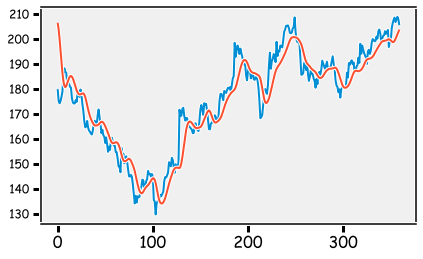

In [303]:
high_pred = model.predict(X_test)
matrix = np.zeros((dataset_test.shape))
matrix = matrix[64:, :]
matrix[:, 1] = high_pred.reshape(-1)
high_pred = scaler.inverse_transform(matrix)[:, 1]
matrix = np.zeros((dataset_test.shape))
matrix = matrix[64:, :]
matrix[:, 1] = dataset_test[64:, 1]
high = scaler.inverse_transform(matrix)[:, 1]
plt.plot(high)
plt.plot(high_pred)

Even though the actua price are way more noisy than the predictions, We can surely say that the model extracted significant pattern from the time series. I can move on and implement the portfolio strategy.

### Defining the strategy: stop loss and stop gain

The first principle of this strategy is the full automation: We don't want to spend the whole day to check stock prices so this strategy will be applicable without any kind of supervision. Note that since I am using only daily data this decision will led to possible underperfomance compared to a person who check for prices every minute. Since my analysis involves just one stock the only decisions needed to implement a strategy will be when to buy and when to sell.

Stop gain on 95 quantile : 0.03515906947539165
Stop loss long on 95th quantile:  -0.02


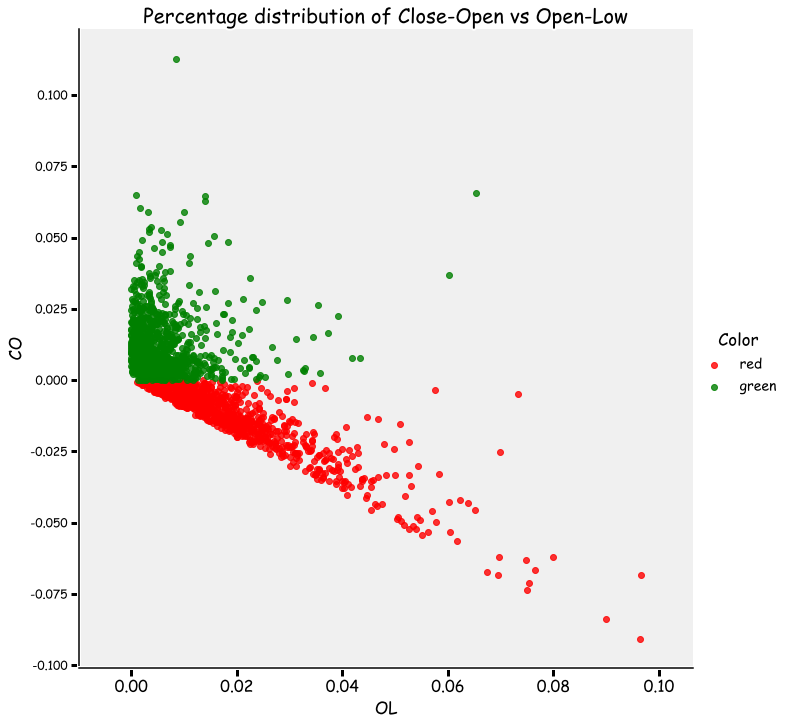

In [370]:
df = load_data(tickers, start, end)
df['OL'] = (df.fbopen - df.fblow) / df.fbopen
df['CO'] = (df.fbclose - df.fbopen) / df.fbopen
df['HO'] = (df.fbhigh - df.fbopen) / df.fbopen
df['Color'] = list(map(lambda x: 'red' if x < 0 else 'green', df.CO))
sns.lmplot(x = 'OL', y = 'CO', height = 10, hue = 'Color', data = df, fit_reg = False,
           palette = dict(red = 'red', green = 'green'))
ax = plt.gca()
ax.set_title('Percentage distribution of Close-Open vs Open-Low')

pct_gain = ((df['fbhigh'] - df['fbopen']) / df['fbopen']).quantile(.95)
print('Stop gain on 95 quantile :', pct_gain)
stop_loss_long_95 = round(-df[df['CO'] > 0]['OL'].quantile(.95), 2)
print('Stop loss long on 95th quantile: ', stop_loss_long_95)

### Strategy implementation

The first control that I applied is about the training mse: I want to trade in days where the difference between the open and the predicted high is greater than the standard error. A good starting point to improve this part is to compute the standard error on a third set and use it as a parameter for the strategy, since this will give a more realistic estimation of it. Now that I have the entry point, set as the open of a trading day, I just need to define the exit. I am going to use the pct_gain computed before as stop gain in the case in which the actual High is greater than it, for all the other situation the close will be the exit point. The Close as exit point brings some kind of inefficency in the strategy, with the trade off of its simplicity. A good way to improve this strategy would be to gather hourly data an analyze the time distribution of the four features I used

In [414]:
from sklearn.metrics import mean_squared_error
import math

me = math.sqrt(mean_squared_error(high, high_pred))

backtest = pd.DataFrame([high, df_test[64:, 3], df_test[64:, 0], high_pred]).transpose()
backtest.columns = ['high', 'close', 'open', 'high_pred']
backtest.dropna(inplace = True)

backtest['trading'] = (abs(backtest['high_pred'] - backtest['open']) > me).astype('int')
def gain_loss(df):
    gl = []
    for i in range(len(df)):
        if (df['trading'][i] == True) & (df['open'][i] * (1 + pct_gain) < df['high'][i]):
            gl.append(1 + pct_gain)
        elif (df['trading'][i] == True) & (df['open'][i] * (1 + pct_gain) > df['high'][i]):
            gl.append(df['close'][i] / df['open'][i])
        else:
            gl.append(1)
    return gl

backtest['Return'] = gain_loss(backtest)

### Strategy evaluation

I am gonna plot the result of the portfolio perfomance with a capital of 10000€. In addition Wd can see the portfolio Sharpe ration computed with a risk free of 0.35% (german bond). The X axis has as unit of measure days, so the strategy operated on almost 2 years of trading.

Final equity: 10355.149
Total percentage return: 3.551 %
Return standard deviation: 0.00996
Sharpe ratio: 3.5636


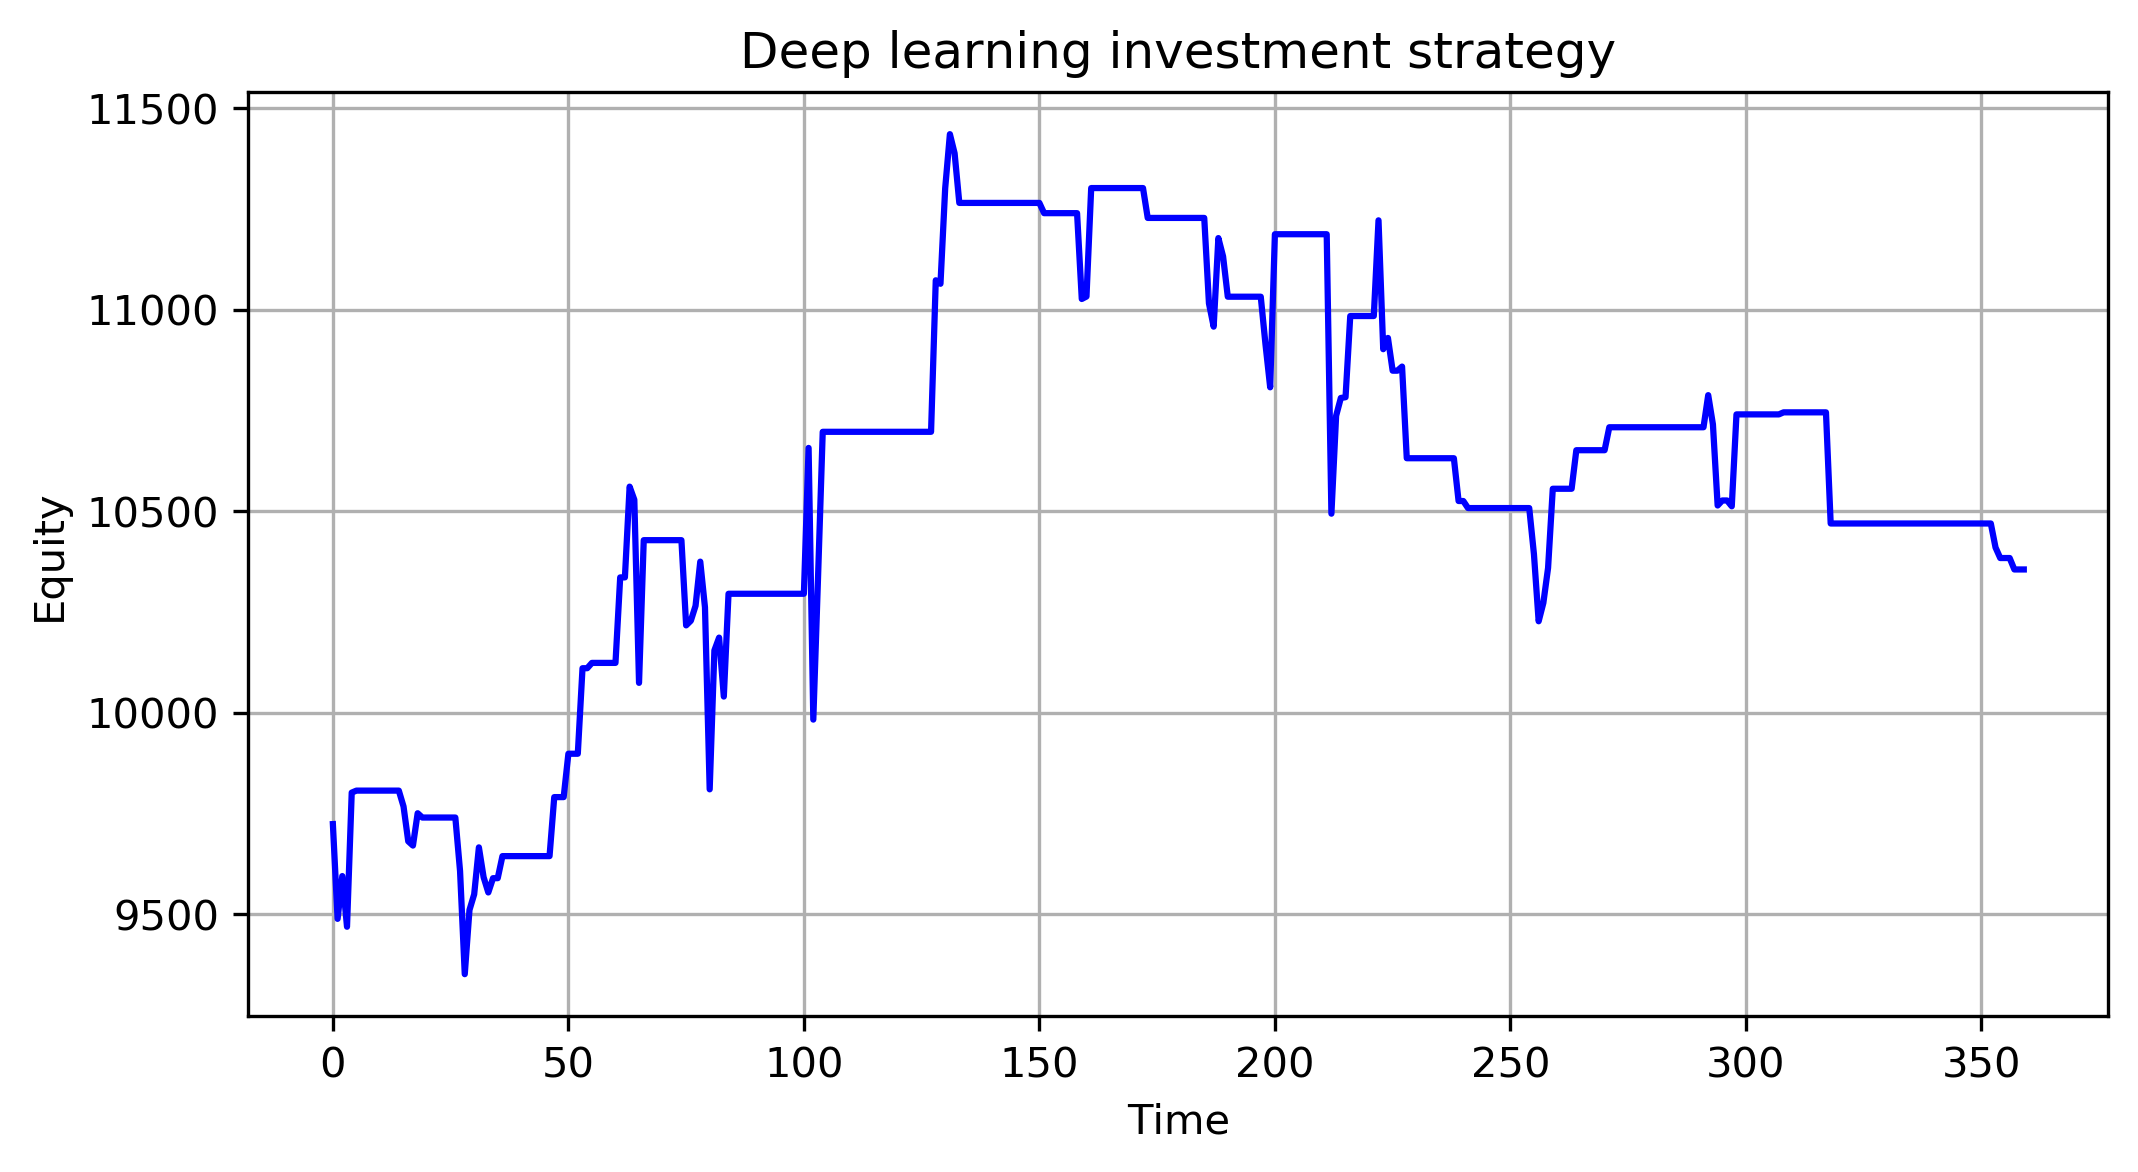

In [424]:
def compute_equity(Return, money):
    return money * Return.cumprod()

money = 10000
rf = 0.0035
equity = compute_equity(backtest['Return'], money)

plt.style.use('default')

print('Final equity: {}'.format(round(equity.iloc[-1], 3)))
return_ = (equity.iloc[-1] - money) * 100 / money
print('Total percentage return: {} %'.format(round(return_, 3)))
std = equity.pct_change().std()
print('Return standard deviation: {}'.format(round(std, 5)))
sr = (return_ - rf) / (std * 100)
print('Sharpe ratio: {}'.format(round(sr, 4)))
plt.figure(figsize = (8, 4), dpi = 300)
plt.plot(equity, color = 'blue', linewidth = 1.5)
plt.xlabel('Time (days)')
plt.ylabel('Equity')
plt.title('Deep learning investment strategy')
plt.grid(True)

### Conclusion

The strategy implemented scored remarkable perfomance on the test period. During the project I highlighted some key points on which readers can work on in order to achieve (theoric) higher perfomance. Said so, It is important to specify that stock markets follow different statistical pattern rather than the one extracted by recurrent neural network, therefore do not rely too much on this kind of model to make money. However, If We want to implement a consistent strategy based on deep learning a good starting point would be to spend a part of our budget to acquire data on a minute basis. Besides this, create a validation and a test set could reduce the overfitting of the model and generate higher return.